# Exploratory Data Analysis on Top 50 Spotify Tracks

In this notebook, I am going to explain how I prepared my data, the features of my data, the analysis I did on the data, and discuss what improvements/further analysis I could make in future work. For convenience, a link to each section is provided:

- [Data Prepation](#data-prep)
- [Features](#features)
- [Analysis](#analysis)
- [Improvements and Future Analysis](#improvements)



I will start by import pandas and numpy, and import the data from the CSV.

In [746]:
import pandas as pd
import numpy as np

toptracks_df = pd.read_csv('spotifytoptracks.csv', index_col=0)


## Data Prepation<a name="data-prep"></a>


The columns appear to be named sensibly:

In [747]:
toptracks_df.columns

Index(['artist', 'album', 'track_name', 'track_id', 'energy', 'danceability',
       'key', 'loudness', 'acousticness', 'speechiness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'genre'],
      dtype='object')

And there appears to be no missing data:

In [748]:
toptracks_df.isna().sum().sum()

np.int64(0)

Plus the artists (of which there are 40) and track names (of which there are 50) appear to contain no obvious duplicates:

In [749]:
print("Number of unique artists:",len(toptracks_df.artist.unique()))
print(np.sort(toptracks_df.artist.unique()))

Number of unique artists: 40
['24kGoldn' 'Ariana Grande' 'Arizona Zervas' 'BENEE' 'BTS' 'Bad Bunny'
 'Billie Eilish' 'Black Eyed Peas' 'Cardi B' 'DaBaby' 'Doja Cat' 'Drake'
 'Dua Lipa' 'Eminem' 'Future' 'Harry Styles' 'JP Saxe' 'Jawsh 685'
 'Juice WRLD' 'Justin Bieber' 'KAROL G' 'Lady Gaga' 'Lewis Capaldi'
 'Lil Mosey' 'Maluma' 'Maroon 5' 'Post Malone' 'Powfu' 'Regard'
 'Roddy Ricch' 'SAINt JHN' 'Shawn Mendes' 'Surf Mesa' 'Surfaces'
 'THE SCOTTS' 'The Weeknd' 'Tones And I' 'Topic' 'Travis Scott'
 'Trevor Daniel']


In [750]:
print("Number of unique track names:", len(toptracks_df.track_name.unique()))
print(np.sort(toptracks_df.track_name.unique()))

Number of unique track names: 50
['Adore You' 'Before You Go' 'Blinding Lights' 'Blueberry Faygo'
 'Break My Heart' 'Breaking Me' 'Circles' 'Dance Monkey' "Don't Start Now"
 'Dynamite' 'Falling' 'Godzilla (feat. Juice WRLD)' 'HIGHEST IN THE ROOM'
 'Hawái' 'If the World Was Ending - feat. Julia Michaels'
 'Intentions (feat. Quavo)' 'Life Is Good (feat. Drake)' 'Lucid Dreams'
 'Memories' 'Mood (feat. iann dior)' 'Physical'
 'RITMO (Bad Boys For Life)' 'ROCKSTAR (feat. Roddy Ricch)' 'ROXANNE'
 'Rain On Me (with Ariana Grande)' 'Ride It' 'Roses - Imanbek Remix'
 'SICKO MODE' 'Safaera' 'Savage Love (Laxed - Siren Beat)' 'Say So'
 'Señorita' 'Someone You Loved' 'Stuck with U (with Justin Bieber)'
 'Sunday Best' 'Sunflower - Spider-Man: Into the Spider-Verse'
 'Supalonely (feat. Gus Dapperton)' 'THE SCOTTS' 'The Box' 'Toosie Slide'
 'Tusa' 'WAP (feat. Megan Thee Stallion)' 'Watermelon Sugar' 'Yummy'
 'bad guy' 'death bed (coffee for your head)' 'everything i wanted'
 'goosebumps' 'ily (i love

Several songs have additional artists listed in the track names. These are identified by either 'feat.' or 'with'. I have extracted these into their own column using a regex expression.

This adds an additional 7 artists, bringing the total number of artists (including second artists) to 47.

In [751]:
import re

def second_artist(r):
    matches = re.findall(r'^.*(?:feat\.|with) (\w+(?: ?\w*)*)\)?$',r)
    if matches:
        return matches[0]
    else:
        return None

toptracks_df['second_artist'] = toptracks_df.track_name.apply(second_artist)
toptracks_df[toptracks_df.second_artist.notna()][['artist','second_artist']]


,artist,second_artist
5,DaBaby,Roddy Ricch
14,Justin Bieber,Quavo
19,Future,Drake
23,24kGoldn,iann dior
27,Cardi B,Megan Thee Stallion
29,Eminem,Juice WRLD
33,BENEE,Gus Dapperton
34,Surf Mesa,Emilee
35,Lady Gaga,Ariana Grande
44,Billie Eilish,Khalid


In [752]:
len(np.union1d(toptracks_df.artist.unique(),  toptracks_df.second_artist.dropna().unique()))

47

At least one genre (Electro-pop) has additional whitespace, so I have striped this across all string (object) columns to ensure better data quality.

In [753]:
toptracks_df = toptracks_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

### Outliers

As all of the data appears to be actual data and to fit what's expected for songs, I will not be excluding any tracks from the analysis. There are a few outliers in a few categories e.g.:
1. The track 'everything i wanted' has a significantly lower loudness than any other track
2. Two tracks ('Safaera' and 'SICKO MODE') have a significantly longer time than any other track (295 and 312 seconds respectively)
3. The track 'Safaera' is the only track to have a completely different genre - all other tracks are some variant of Pop, Hip-Hop, Electronic or Indie

While I will not be excluding any of these from the analysis, when I focus in on these categories, I will be discussing the impact of these outliers and how certain statistics change when these outliers are excluded. 

## Features<a name="features"></a>

There are 50 observations in this data set, each with 16 features. Of these 16 features, 10 are numeric, 6 are categorical. I have also extracted the second artist, which is an additional categorical feature.

#### Numeric features
- energy
    - How energetic the track is - between 0 and 1, 1 is highly energetic
- danceability
    - How easy it is to dance to the track - between 0 and 1, 1 is highly danceable
- loudness
    - How loud the track is - a higher number indicates a louder track
- acousticness
    - How acoustic the track sounds - between 0 and 1, 1 is highly acoustic
- speechiness
    - The presence of spoken words - between 0 and 1, 1 is fully spoken words
- instrumentalness
    - Whether the track is likely to have vocals - between 0 and 1, 1 is very likely to have no vocals whatsoever
- liveness
    - Whether the track is likely to be a live performance - between 0 and 1, 1 is very likely to be live
- valence
    - The positivity of the track - between 0 and 1, 1 is highly positive
- tempo
    - Beats per minute
- duration_ms
    - Duration of the track in milliseconds

#### Categorical features
- key
    - Primary identifier of the track
- genre
    - Genre of the track
- artist
    - Artist of the track
- album
    - Album of the track
- track_name
    - Name of the track
- track_id
    - ID of the track

#### Extracted data 
- second_artist (categorical)
    - Second artist of the track (optional)

## Analysis<a name="analysis"></a>

I have analysed the data, focusing on the below aspects:

- [Artists](#artists)
- [Albums](#albums)
- [Genre](#genre)
- [Tracks](#tracks)
- [Correlations](#correlations)

### Artists<a name="artists"></a>

Questions about the artists:
1. [Which artists have more than 1 popular track? How many tracks does each of these artist have?](#artists-q1)
2. [How many artists are in the top 50?](#artists-q2)
3. [Which artist is the most popular?](#artists-q3)



#### Question 1: Which artists have more than 1 popular track? How many tracks does each of these artist have?<a name="artists-q1"></a>

Of the 40 artists in the top 50, 7 have more than 1 popular track. The highest number of tracks is 3, which 3 artists have: 
Billie Eilish, Dua Lipa, Travis Scott. 

In [754]:
no_tracks_per_artist = toptracks_df.groupby('artist').track_name.count().sort_values(ascending=False)
mult_track_artists = no_tracks_per_artist[no_tracks_per_artist > 1]
print("Number of artists with more than 1 top 50 track:",len(mult_track_artists))
print(mult_track_artists)


Number of artists with more than 1 top 50 track: 7
artist
Billie Eilish    3
Dua Lipa         3
Travis Scott     3
Lewis Capaldi    2
Harry Styles     2
Post Malone      2
Justin Bieber    2
Name: track_name, dtype: int64


If we include artists who are the second artist on a track, this changes to 11 artists with more than 1 top 50 track. The maximum number of tracks (3) doesn't change, but an extra artist now has 3 tracks (4 total - Justin Bieber has been added).

In [755]:
second_artist_count = toptracks_df.groupby('second_artist').track_name.count().sort_values(ascending=False)
second_artist_incl = no_tracks_per_artist.add(second_artist_count, fill_value = 0).sort_values(ascending=False)
print("Number of artists with more than 1 top 50 track (when including tracks as second artist):",len(second_artist_incl[second_artist_incl > 1]))
print(second_artist_incl[second_artist_incl > 1])

Number of artists with more than 1 top 50 track (when including tracks as second artist): 11
Billie Eilish    3.0
Dua Lipa         3.0
Justin Bieber    3.0
Travis Scott     3.0
Juice WRLD       2.0
Drake            2.0
Ariana Grande    2.0
Harry Styles     2.0
Lewis Capaldi    2.0
Roddy Ricch      2.0
Post Malone      2.0
Name: track_name, dtype: float64


#### Question 2: How many artists are in the top 50?<a name="artists-q2"></a>

There are 40 artists listed as the main artist in the top 50.

In [756]:
len(toptracks_df.artist.unique())

40

If we include second artists, this increase to 47 artists.

In [757]:
len(np.union1d(toptracks_df.artist.unique(), toptracks_df.second_artist.dropna().unique()))

47

#### Question 3: Who was the most popular artist?<a name="artists-q3"></a>

In order to assess this more accurately, I beleive we would require play counts. Knowing which songs were played the most would make it easier to determine which artist(s) were more popular. 

Without this data, the above analysis of the most popular track per artist is the best way of assessing this. I believe it's reasonable to say that being the main artist ranks above being the second artist, so we can consider the 3 artists who had 3 popular songs as the most popular artists:
- Billie Eilish
- Dua Lipa
- Travis Scott

### Albums<a name="albums"></a>

Questions about albums:
1. [Which albums have more than 1 track in the top 50? How many tracks do each of these albums have in the top 50?](#albums-q1)
2. [How many ablums are in the top 50?](#albums-q2)

#### Question 1: Which albums have more than 1 track in the top 50? How many tracks do each of these albums have in the top 50?<a name="albums-q1"></a>

4 albums have more than 1 track in the top 50. The most tracks for a single album is 3, which only the album Future Nostalgia managed. The artist is Dua Lipa and the tracks are: Don't Start Now; Break My Heart; Physical. 

In [758]:
album_counts = toptracks_df.album.value_counts().sort_values(ascending=False)
print("Number of albums with more than 1 track:", len(album_counts[album_counts > 1]))
print(album_counts[album_counts > 1])

Number of albums with more than 1 track: 4
album
Future Nostalgia        3
Hollywood's Bleeding    2
Fine Line               2
Changes                 2
Name: count, dtype: int64


In [759]:
toptracks_df[toptracks_df['album'] == 'Future Nostalgia']

,artist,album,track_name,track_id,energy,danceability,key,loudness,acousticness,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,genre,second_artist
4,Dua Lipa,Future Nostalgia,Don't Start Now,3PfIrDoz19wz7qK7tYeu62,0.793,0.793,11,-4.521,0.0123,0.0830,0.000000,0.0951,0.679,123.950,183290,Nu-disco,None
31,Dua Lipa,Future Nostalgia,Break My Heart,017PF4Q3l4DBUiWoXk4OWT,0.729,0.730,4,-3.434,0.1670,0.0883,0.000001,0.3490,0.467,113.013,221820,Dance-pop/Disco,None
48,Dua Lipa,Future Nostalgia,Physical,3AzjcOeAmA57TIOr9zF1ZW,0.844,0.647,0,-3.756,0.0137,0.0457,0.000658,0.1020,0.746,146.967,193829,Dance/Electronic,None


#### Question 2: How many ablums are in the top 50?<a name="albums-q2"></a>

45 albums have songs in the top 50. 

In [760]:
len(album_counts)

45

### Genre<a name="genre"></a>

Questions about genre:
1. [Which genre is the most popular?](#genre-q1)
2. [Which genres have just one song on the top 50?](#genre-q2)
3. [How many genres in total are represented in the top 50?](#genre-q3)

The provided genres contain both sub-categories and categories, as well as some tracks having multiple genres. It's difficult to tell with the current data which genres are part of the same parent genre, and exactly how many genres are represented in the top 50. We would be able to get a more comprehensive view about which genres are the most popualar if we had the parent genres (e.g. Disco-pop and Nu-disco are both part of the Disco genre, which in turn is part of the Electronic genre), and if tracks with multiple genres (e.g. Pop/Soft Rock) were split out.

Most tracks fall under some form of Pop or Hip-hop.  

#### Question 1: Which genre is the most popular?<a name="genre-q1"></a>

Based on the genres provided, Pop is the most popular, with 14 tracks.

In [761]:
genre_counts = toptracks_df.genre.value_counts()
print(genre_counts)

genre
Pop                                   14
Hip-Hop/Rap                           13
Dance/Electronic                       5
Alternative/Indie                      4
R&B/Soul                               2
Electro-pop                            2
R&B/Hip-Hop alternative                1
Nu-disco                               1
Pop/Soft Rock                          1
Pop rap                                1
Hip-Hop/Trap                           1
Dance-pop/Disco                        1
Disco-pop                              1
Dreampop/Hip-Hop/R&B                   1
Alternative/reggaeton/experimental     1
Chamber pop                            1
Name: count, dtype: int64


#### Question 2: Which genres have just one song on the top 50?<a name="genre-q2"></a>

10 genres have only one track in the top 50. However, we can see from the below list that most of these genres appear to fit into the same parent genre or share at least 1 genre with at least one other track. Arguably, the only track that actually has a unique genre is 'Safaera' by Bad Bunny, with the genre Alternative/reggaeton/experimental. 

In [762]:
print("Number of genres with only 1 track:", len(genre_counts[genre_counts == 1]))
print(genre_counts[genre_counts == 1])

Number of genres with only 1 track: 10
genre
R&B/Hip-Hop alternative               1
Nu-disco                              1
Pop/Soft Rock                         1
Pop rap                               1
Hip-Hop/Trap                          1
Dance-pop/Disco                       1
Disco-pop                             1
Dreampop/Hip-Hop/R&B                  1
Alternative/reggaeton/experimental    1
Chamber pop                           1
Name: count, dtype: int64


In [763]:
toptracks_df[toptracks_df['genre'] == 'Alternative/reggaeton/experimental'][['artist','track_name']]

,artist,track_name
43,Bad Bunny,Safaera


#### Question 3: How many genres in total are represented in the top 50?<a name="genre-q3"></a>

There are 16 sub-genres represented in the top 50. This count could be improved by getting the parent genres and splitting out tracks with multiple genres.

In [764]:
len(genre_counts)

16

### Tracks<a name="tracks"></a>

Questions about tracks:

1. [Danceability](#danceability)<br/>
    a. [Which tracks have the highest danceability?](#tracks-danceability-q1)<br/>
    b. [Which tracks have the lowest danceability?](#tracks-danceability-q2)<br/>
    c. [How does danceability compare across genres?](#tracks-danceability-q3)<br/>
2. [Loudness](#loudness)<br/>
    a. [Which tracks are the loudest?](#tracks-loudness-q1)<br/>
    b. [Which tracks are the quietest?](#tracks-loudness-q2)<br/>
    c. [How does loudness compare across genres?](#tracks-loudness-q3)<br/>
3. [Acousticness](#acousticness)<br/>
    a. [How does acousticness compare across genres?](#tracks-acousticness-q1)<br/>
4. [Track length](#track-length)<br/>
    a. [Which track is the longest?](#tracks-length-q1)<br/>
    b. [Which track is the shortest?](#tracks-length-q2)<br/>

When comparing across genres, I will limit the comparison to: Pop; Hip-Hop/Rap; Dance/Electronic; and Alternative/Indie. These are the 4 most used genres and thus will give the most insightful results.

#### Danceability<a name="danceability"></a>

Danceability is measured from 0 (completely un-danceable) to 1 (completely danceable). On average, tracks in the top 50 have high danceability, with a mean of 0.717 and median of 0.746. Danceability is moderately negatively skewed. This can be seen in the histogram, as the highest concentration of track is seen within about $\pm$ 0.1 of the mean danceability, with most being just above the mean, but there is also a long, shallower tail into low danceability.

From this, we can see that more danceable songs are typically more popular, although this is not always the case.

In [765]:
print(f"Mean danceability: {toptracks_df.danceability.mean():.3f}")
print(f"Median danceability: {toptracks_df.danceability.median():.3f}")
print(f"Skew: {toptracks_df.danceability.skew():.3f}")

Mean danceability: 0.717
Median danceability: 0.746
Skew: -0.882


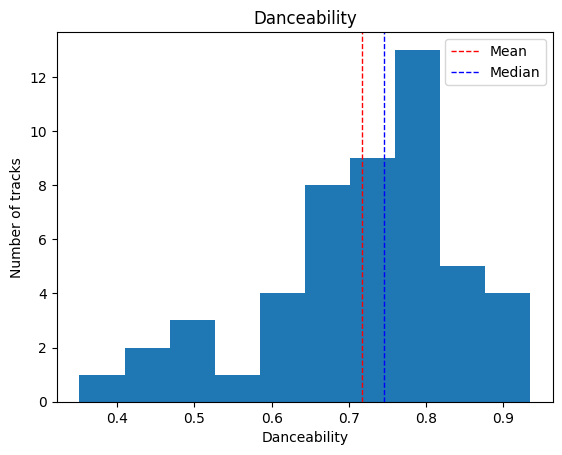

In [766]:
import matplotlib.pyplot as plt

plt.hist(toptracks_df.danceability)
plt.xlabel('Danceability')
plt.ylabel('Number of tracks')
plt.title('Danceability')
plt.axvline(toptracks_df.danceability.mean(), color='r', linestyle='dashed', linewidth=1, label = 'Mean')
plt.axvline(toptracks_df.danceability.median(), color='b', linestyle='dashed', linewidth=1, label = 'Median')
plt.legend()

##### Question 1: Which tracks have the highest danceability?<a name="tracks-danceability-q1"></a>

We can consider a track with danceability of more than 0.7 as having high danceability. 32 tracks have a danceability score more than 0.7, with 'WAP (feat. Megan Thee Stallion)' by Cardi B being the most danceable track. This is in keeping with the above discussion about negative skew, as 64% of the top 50 tracks have high danceability.


In [767]:
danceable_tracks = toptracks_df[toptracks_df['danceability'] > 0.7][['track_name','danceability']].sort_values(by='danceability',ascending=False).set_index('track_name')
print("Number of danceable tracks:", len(danceable_tracks))
print(danceable_tracks)

Number of danceable tracks: 32
                                               danceability
track_name                                                 
WAP (feat. Megan Thee Stallion)                       0.935
The Box                                               0.896
Ride It                                               0.880
Sunday Best                                           0.878
Supalonely (feat. Gus Dapperton)                      0.862
goosebumps                                            0.841
SICKO MODE                                            0.834
Toosie Slide                                          0.830
Dance Monkey                                          0.825
Godzilla (feat. Juice WRLD)                           0.808
Intentions (feat. Quavo)                              0.806
Tusa                                                  0.803
Life Is Good (feat. Drake)                            0.795
Don't Start Now                                       0.793
Breaking 

##### Question 2: Which tracks have the lowest danceability?<a name="tracks-danceability-q2"></a>

We can consider a track with danceability of less than 0.4 as having low danceability. Only 1 song ('lovely (with Khalid)' by Billie Eilish) has a low danceability score. 

In [768]:
undanceable_tracks = toptracks_df[toptracks_df['danceability'] < 0.4][['track_name','danceability']].sort_values(by='danceability',ascending=False).set_index('track_name')
print("Number of un-danceable tracks:", len(undanceable_tracks))
print(undanceable_tracks)

Number of un-danceable tracks: 1
                      danceability
track_name                        
lovely (with Khalid)         0.351


##### Question 3: How does danceability compare across genres?<a name="tracks-danceability-q3"></a>

When comparing danceability between the genres Pop (P); Hip-Hop/Rap (HR); Dance/Electronic (DE); and Alternative/Indie (AI), we find that:

1. HR has the highest mean dancability, but DE has the highest median. These genres are highly danceable. P and AI have lower averages but still have similarly high average danceabilities.
2. HR and DE have very similar summary statistics (mean, median and max are all only different by 0.01) but noticably different distributions (DE has a slight positive skew, whereas HR has a much more pronounced negative skew). We can see this in the plot, where DE is mostly evenly spaced and centered around its average but slightly concentrated just below, whereas HR has a longer tail with a lower minimum danceability but is concentrated above its average.
3. Similar to HR and DE, P and AI also have very similar summary statistics (mean and min are within about 0.01) but again AI has almost no skew at all whereas P have a much more pronounced negative skew, again concentrating just above its average but having a long tail and low minimum.
4. AI is the most spread out of any genre, with either very high or very low danceability. The other genres have less spread, with DE appearing the least spread out on the graph and HR having the lowest standard deviation and variance (although DE is only marginally more).
5. AI has the lowest minimum danceability. There is a significant different between the minimum danceabilities, with a different of almost 0.2 between AI and DE (which has the highest minimum), suggesting DE tracks are rarely not danceable and that generally, some genres are always danceable.
6. HR has the highest maximum danceability, however however there isn't significant variation between the maximum danceability across the genres (<0.1). This suggests that most genres are capable of being highly danceable, even if it's not typical for that genre.


In [769]:
toptracks_df.groupby('genre').danceability.agg(['mean','median','max','min','std','var','skew']).loc[['Pop', 'Hip-Hop/Rap','Dance/Electronic','Alternative/Indie']]

,mean,median,max,min,std,var,skew
genre,,,,,,,
Pop,0.677571,0.690,0.806,0.464,0.109853,0.012068,-0.710864
Hip-Hop/Rap,0.765538,0.774,0.896,0.598,0.085470,0.007305,-0.721079
Dance/Electronic,0.755000,0.785,0.880,0.647,0.094744,0.008976,0.111838
Alternative/Indie,0.661750,0.663,0.862,0.459,0.211107,0.044566,-0.007631


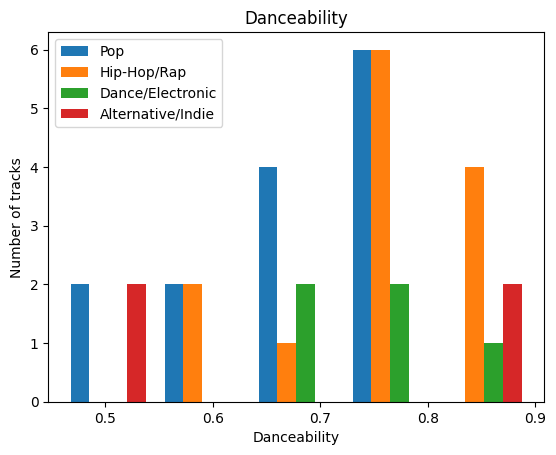

In [770]:
danceabilities_plot = [toptracks_df[toptracks_df['genre'] == 'Pop'].danceability,toptracks_df[toptracks_df['genre'] == 'Hip-Hop/Rap'].danceability,toptracks_df[toptracks_df['genre'] == 'Dance/Electronic'].danceability,toptracks_df[toptracks_df['genre'] == 'Alternative/Indie'].danceability]

plt.hist(danceabilities_plot, label=['Pop', 'Hip-Hop/Rap', 'Dance/Electronic', 'Alternative/Indie'], bins=5)
plt.xlabel('Danceability')
plt.ylabel('Number of tracks')
plt.title('Danceability')
plt.legend()


#### Loudness<a name="loudness"></a>

Loudness is a continuous variable. In our dataset, loudness ranges between -14.5 and -3.2. Tracks get louder as loudness gets closer to 0. Loudness is strongly negatively skewed, meaning most of the top 50 are louder tracks - this can be seen on the graph, with the loudest bin having the most tracks.

In [771]:
print(f"Mean loudness: {toptracks_df.loudness.mean():.3f}")
print(f"Median loudness: {toptracks_df.loudness.median():.3f}")
print(f"Max loudness: {toptracks_df.loudness.max():.3f}")
print(f"Min loudness: {toptracks_df.loudness.min():.3f}")
print(f"Skew: {toptracks_df.loudness.skew():.3f}")

Mean loudness: -6.226
Median loudness: -5.992
Max loudness: -3.280
Min loudness: -14.454
Skew: -1.032


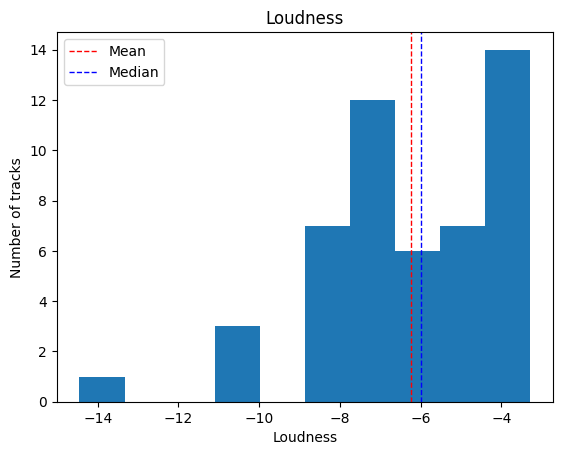

In [772]:
plt.hist(toptracks_df.loudness)
plt.xlabel('Loudness')
plt.ylabel('Number of tracks')
plt.title('Loudness')
plt.axvline(toptracks_df.loudness.mean(), color='r', linestyle='dashed', linewidth=1, label = 'Mean')
plt.axvline(toptracks_df.loudness.median(), color='b', linestyle='dashed', linewidth=1, label = 'Median')
plt.legend()

From this graph, we can see that most tracks are centered pretty equally around around the average loudness (although this is not a perfect distrubtion). Only 4 tracks are significantly outside of the main distribution. We can see that all of these are some form of Pop, suggesting this genre may be quieter. We can also see that, when excluding these 4 tracks, that the average increases slightly, and the skew decreases substainally.  

In [773]:
toptracks_df[toptracks_df.loudness < -10][['track_name','loudness','genre']]

,track_name,loudness,genre
24,everything i wanted,-14.454,Pop
26,bad guy,-10.965,Electro-pop
44,lovely (with Khalid),-10.109,Chamber pop
47,If the World Was Ending - feat. Julia Michaels,-10.086,Pop


In [774]:
print(f"Mean loudness: {toptracks_df[toptracks_df.loudness >= -10].loudness.mean():.3f}")
print(f"Median loudness: {toptracks_df[toptracks_df.loudness >= -10].loudness.median():.3f}")
print(f"Skew: {toptracks_df[toptracks_df.loudness >= -10].loudness.skew():.3f}")

Mean loudness: -5.776
Median loudness: -5.665
Skew: -0.188


##### Question 1: Which tracks are the loudest?<a name="tracks-loudness-q1"></a>

We can consider a track loud when its loudness is more than -5. There are 19 loud tracks, with the loudest being 'Tusa'. This suggests that it is common for popular tracks to be loud, although they don't need to be loud to be popular.

In [775]:
loud_tracks = toptracks_df[toptracks_df['loudness'] > -5][['track_name','loudness']].sort_values(by='loudness',ascending=False).set_index('track_name')
print("Number of loud tracks:", len(loud_tracks))
print(loud_tracks)

Number of loud tracks: 19
                                               loudness
track_name                                             
Tusa                                             -3.280
goosebumps                                       -3.370
Break My Heart                                   -3.434
Hawái                                            -3.454
Circles                                          -3.497
Mood (feat. iann dior)                           -3.558
Adore You                                        -3.675
SICKO MODE                                       -3.714
Physical                                         -3.756
Rain On Me (with Ariana Grande)                  -3.764
Safaera                                          -4.074
Watermelon Sugar                                 -4.209
Ride It                                          -4.258
Sunflower - Spider-Man: Into the Spider-Verse    -4.368
Dynamite                                         -4.410
Don't Start Now       

##### Question 2: Which tracks are the quiestest?<a name="tracks-loudness-q2"></a>

We can consider a track quiet when its loudness is less than -8. There are 9 quiet tracks, of which the quietest is 'everything i wanted'. Similar to loud tracks, this suggests that it's not uncommon for popular tracks to be quiet (although about half as common as loud tracks), but on average, popular tracks are neither particularly quiet or loud.

In [776]:
quiet_tracks = toptracks_df[toptracks_df['loudness'] < -8][['track_name','loudness']].sort_values(by='loudness').set_index('track_name')
print("Number of quiet tracks:", len(quiet_tracks))
print(quiet_tracks)

Number of quiet tracks: 9
                                                loudness
track_name                                              
everything i wanted                              -14.454
bad guy                                          -10.965
lovely (with Khalid)                             -10.109
If the World Was Ending - feat. Julia Michaels   -10.086
Toosie Slide                                      -8.820
death bed (coffee for your head)                  -8.765
HIGHEST IN THE ROOM                               -8.764
Falling                                           -8.756
Savage Love (Laxed - Siren Beat)                  -8.520


##### Question 3: How does loudness compare across genres?<a name="tracks-loudness-q3"></a>

When comparing loudness between the genres Pop (P); Hip-Hop/Rap (HR); Dance/Electronic (DE); and Alternative/Indie (AI), we find that:
1. All genres has at least moderate skew, suggesting extreme values are common across genres. P has the strongest skew, which can be seen in the graph, as it's the only genre with very low loudnesses.
2. Only HR has positive skew, the other genres have negative skews. This suggests that being quieter is more typical for HR, whereas being louder is more typical for the other genres.
3. P has by far the highest deviation and variance, which can be seen on the graph - the other genres are clustered much closer together, whereas P is more spread out. 
4. AI has the smallest deviation of the genres and skews towards louder tracks.
5. There is much more difference in the quietest tracks of each genre, compared to the difference in the loudest tracks. Some genres have a much higher minimum than others (e.g. DE and AI). This suggests any genre can have loud tracks but only some genres have quiet or very quiet tracks.
6. DE and AI are the loudest genres, and have very similar averages. DE has a higher max loudness but lower min loudness, and has more variation in loudness compared to AI. 

In [777]:
toptracks_df.groupby('genre').loudness.agg(['mean','median','max','min','std','var','skew']).loc[['Pop', 'Hip-Hop/Rap','Dance/Electronic','Alternative/Indie']]

,mean,median,max,min,std,var,skew
genre,,,,,,,
Pop,-6.460357,-6.6445,-3.280,-14.454,3.014281,9.085892,-1.466538
Hip-Hop/Rap,-6.917846,-7.6480,-3.370,-8.820,1.891808,3.578936,0.847259
Dance/Electronic,-5.338000,-5.4570,-3.756,-7.567,1.479047,2.187581,-0.758282
Alternative/Indie,-5.421000,-5.2685,-4.746,-6.401,0.774502,0.599853,-0.677828


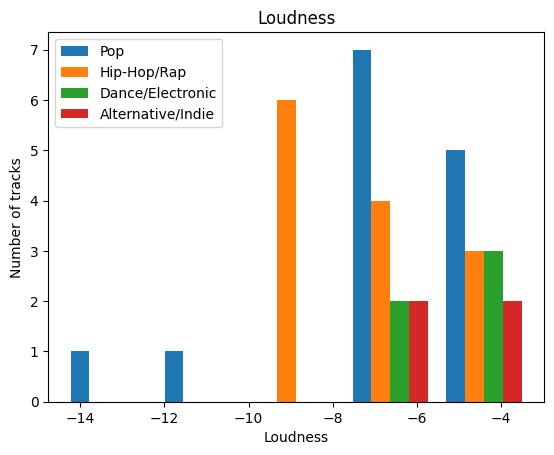

In [778]:
loudness_plot = [toptracks_df[toptracks_df['genre'] == 'Pop'].loudness,toptracks_df[toptracks_df['genre'] == 'Hip-Hop/Rap'].loudness,toptracks_df[toptracks_df['genre'] == 'Dance/Electronic'].loudness,toptracks_df[toptracks_df['genre'] == 'Alternative/Indie'].loudness]

plt.hist(loudness_plot, label=['Pop', 'Hip-Hop/Rap', 'Dance/Electronic', 'Alternative/Indie'], bins=5)
plt.xlabel('Loudness')
plt.ylabel('Number of tracks')
plt.title('Loudness')
plt.legend()

#### Acousticness<a name="acousticness"></a>

Acousticness is a measure of how acoustic a track sounds, measured from 0 (completely not acoustic) to 1 (completely acoustic). On average, tracks in the top 50 are not very acoustic, with a mean of 0.256 and a median of 0.189, and the tracks are strongly positively skewed towards being not acoustic. 17 tracks have very low acousticness (less than 0.1), which is almost twice as many as tracks with acousticness above 0.5. This suggests it's much less common for popular songs to be acoustic. 

In [779]:
print(f"Mean acousticness: {toptracks_df.acousticness.mean():.3f}")
print(f"Median acousticness: {toptracks_df.acousticness.median():.3f}")
print(f"Skew: {toptracks_df.acousticness.skew():.3f}")
print(f"Number of tracks with very low acousticness: {toptracks_df[toptracks_df.acousticness < 0.1].track_name.count()}")
print(f"Number of tracks with higher acousticness: {toptracks_df[toptracks_df.acousticness > 0.5].track_name.count()}")

Mean acousticness: 0.256
Median acousticness: 0.189
Skew: 1.326
Number of tracks with very low acousticness: 17
Number of tracks with higher acousticness: 9


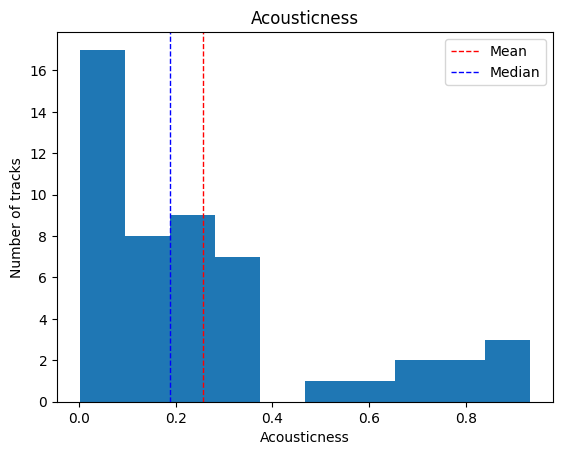

In [780]:
plt.hist(toptracks_df.acousticness)
plt.xlabel('Acousticness')
plt.ylabel('Number of tracks')
plt.title('Acousticness')
plt.axvline(toptracks_df.acousticness.mean(), color='r', linestyle='dashed', linewidth=1, label = 'Mean')
plt.axvline(toptracks_df.acousticness.median(), color='b', linestyle='dashed', linewidth=1, label = 'Median')
plt.legend()

##### Question 1: How does acousticness compare across genres?<a name="tracks-acousticness-q1"></a>

When comparing acousticness between the genres Pop (P); Hip-Hop/Rap (HR); Dance/Electronic (DE); and Alternative/Indie (AI), we find that:
1. Most genres typically have low acousticness, with AI being the only expection - AI tracks typically have high acousticness with only 1 exception, which is still higher than most tracks in the other genres.
2. Only DE has exclusively low acousticness, having a max of 0.223. Every other genre has at least 1 track with high acousticness. 
3. The lowest acousticness in the AI genre is still more than maximum acousticness in the DE genre.
4. While AI has the highest average acousticness (mean: 0.584, median: 0.646), P has the highest instance of acousticness (0.902).
5. DE has the least deviation of the genres and the lowest skew, as it's the most clustered genre.
6. Only AI has negative skew, skewing towards being more acoustic. All other genres have positive skews, towards being less acoustic, with HR in particular being very postively skewed. 

In [781]:
toptracks_df.groupby('genre').acousticness.agg(['mean','median','max','min','std','var','skew']).loc[['Pop', 'Hip-Hop/Rap','Dance/Electronic','Alternative/Indie']]

,mean,median,max,min,std,var,skew
genre,,,,,,,
Pop,0.323843,0.2590,0.902,0.02100,0.318142,0.101215,1.035334
Hip-Hop/Rap,0.188741,0.1450,0.731,0.00513,0.186396,0.034743,2.221335
Dance/Electronic,0.099440,0.0686,0.223,0.01370,0.095828,0.009183,0.515687
Alternative/Indie,0.583500,0.6460,0.751,0.29100,0.204086,0.041651,-1.503933


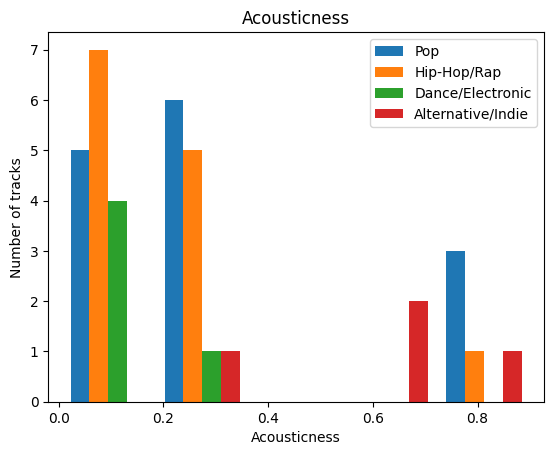

In [782]:
acousticness_plot = [toptracks_df[toptracks_df['genre'] == 'Pop'].acousticness,toptracks_df[toptracks_df['genre'] == 'Hip-Hop/Rap'].acousticness,toptracks_df[toptracks_df['genre'] == 'Dance/Electronic'].acousticness,toptracks_df[toptracks_df['genre'] == 'Alternative/Indie'].acousticness]

plt.hist(acousticness_plot, label=['Pop', 'Hip-Hop/Rap', 'Dance/Electronic', 'Alternative/Indie'], bins=5)
plt.xlabel('Acousticness')
plt.ylabel('Number of tracks')
plt.title('Acousticness')
plt.legend()

#### Track Length<a name="track-length"></a>

On average, top 50 tracks are around 3 minutes and 20 seconds long. There is a strong positive skew, which is mostly accounted for by the 2 longest tracks. The top 50 appear to follow a normal distribution when ignoring these 2 tracks. 

In [783]:
mins_mean_track, secs_mean_track = divmod(toptracks_df.duration_ms.mean() / 1000 / 60, 1)
secs_mean_track = secs_mean_track * 60

mins_median_track, secs_median_track = divmod(toptracks_df.duration_ms.median() / 1000 / 60, 1)
secs_median_track = secs_median_track * 60

mins_max_track, secs_max_track = divmod(toptracks_df.duration_ms.max() / 1000 / 60, 1)
secs_max_track = secs_max_track * 60

mins_min_track, secs_min_track = divmod(toptracks_df.duration_ms.min() / 1000 / 60, 1)
secs_min_track = secs_min_track * 60

print(f"Mean length: {int(mins_mean_track)} minutes {int(secs_mean_track)} seconds")
print(f"Median length: {int(mins_median_track)} minutes {int(secs_median_track)} seconds")
print(f"Max length: {int(mins_max_track)} minutes {int(secs_max_track)} seconds")
print(f"Min length: {int(mins_min_track)} minutes {int(secs_min_track)} seconds")
print(f"Skew: {toptracks_df.duration_ms.skew()}")

Mean length: 3 minutes 19 seconds
Median length: 3 minutes 17 seconds
Max length: 5 minutes 12 seconds
Min length: 2 minutes 20 seconds
Skew: 1.09187639306071


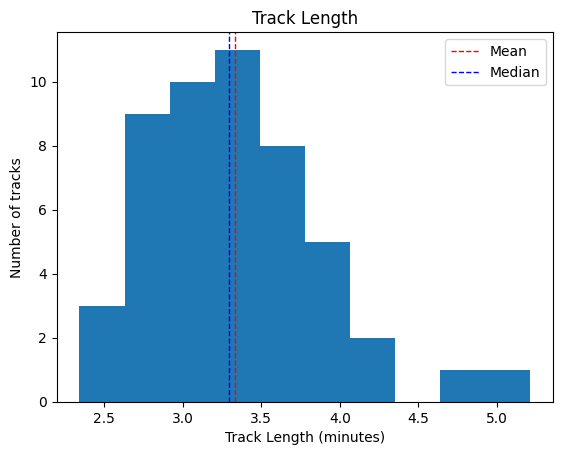

In [784]:
plt.hist(toptracks_df.duration_ms / 1000 / 60)
plt.xlabel('Track Length (minutes)')
plt.ylabel('Number of tracks')
plt.title('Track Length')
plt.axvline(toptracks_df.duration_ms.mean() / 1000 / 60, color='r', linestyle='dashed', linewidth=1, label = 'Mean')
plt.axvline(toptracks_df.duration_ms.median() / 1000 / 60, color='b', linestyle='dashed', linewidth=1, label = 'Median')
plt.legend()

If we remove the 2 outliers from this dataset, we can see that skew decreases significantly and is distributed much more equally. The mean and median are now also equal.

In [785]:
mins_mean_track, secs_mean_track = divmod(toptracks_df[toptracks_df.duration_ms < 275000].duration_ms.mean() / 1000 / 60, 1)
secs_mean_track = secs_mean_track * 60

mins_median_track, secs_median_track = divmod(toptracks_df[toptracks_df.duration_ms < 275000].duration_ms.median() / 1000 / 60, 1)
secs_median_track = secs_median_track * 60

mins_max_track, secs_max_track = divmod(toptracks_df[toptracks_df.duration_ms < 275000].duration_ms.max() / 1000 / 60, 1)
secs_max_track = secs_max_track * 60

mins_min_track, secs_min_track = divmod(toptracks_df[toptracks_df.duration_ms < 275000].duration_ms.min() / 1000 / 60, 1)
secs_min_track = secs_min_track * 60

print(f"Mean length: {int(mins_mean_track)} minutes {int(secs_mean_track)} seconds")
print(f"Median length: {int(mins_median_track)} minutes {int(secs_median_track)} seconds")
print(f"Max length: {int(mins_max_track)} minutes {int(secs_max_track)} seconds")
print(f"Min length: {int(mins_min_track)} minutes {int(secs_min_track)} seconds")
print(f"Skew: {toptracks_df[toptracks_df.duration_ms < 275000].duration_ms.skew()}")

Mean length: 3 minutes 15 seconds
Median length: 3 minutes 15 seconds
Max length: 4 minutes 7 seconds
Min length: 2 minutes 20 seconds
Skew: 0.1855104213978467


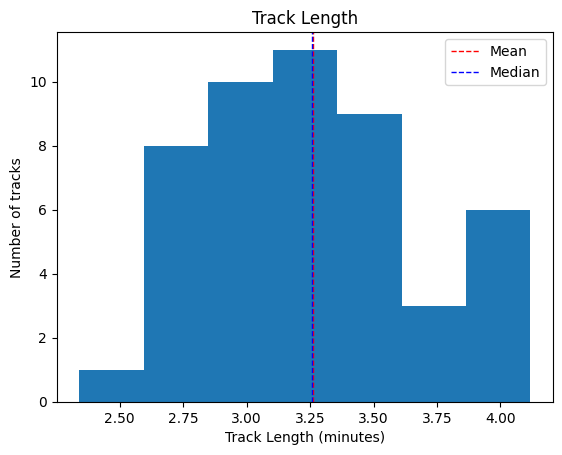

In [786]:
plt.hist(toptracks_df[toptracks_df.duration_ms < 275000].duration_ms / 1000 / 60, bins=7)
plt.xlabel('Track Length (minutes)')
plt.ylabel('Number of tracks')
plt.title('Track Length')
plt.axvline(toptracks_df[toptracks_df.duration_ms < 275000].duration_ms.mean() / 1000 /60 , color='r', linestyle='dashed', linewidth=1, label = 'Mean')
plt.axvline(toptracks_df[toptracks_df.duration_ms < 275000].duration_ms.median() / 1000 /60 , color='b', linestyle='dashed', linewidth=1, label = 'Median')
plt.legend()

##### Question 1: Which track is the longest?<a name="tracks-length-q1"></a>

The track 'SICKO MODE' by Travis Scott is the longest track, at 5 minutes 12 seconds. 

In [787]:
toptracks_df.loc[toptracks_df.duration_ms.idxmax(),['artist','track_name','duration_ms']]

artist         Travis Scott
track_name       SICKO MODE
duration_ms          312820
Name: 49, dtype: object

In [788]:
mins_longest_track, secs_longest_track = divmod(toptracks_df.loc[toptracks_df.duration_ms.idxmax()].duration_ms / 1000 / 60, 1)
secs_longest_track = secs_longest_track * 60
print(f"{int(mins_longest_track)} minutes {int(secs_longest_track)} seconds")


5 minutes 12 seconds


##### Question 2: Which track is the shortest?<a name="tracks-length-q2"></a>

The track 'Mood (feat. iann dior)' by 24kGoldn was the shortest track, at 2 minutes 20 seconds.

In [789]:
toptracks_df.loc[toptracks_df.duration_ms.idxmin(),['artist','track_name','duration_ms']]

artist                       24kGoldn
track_name     Mood (feat. iann dior)
duration_ms                    140526
Name: 23, dtype: object

In [790]:
mins_shortest_track, secs_shortest_track = divmod(toptracks_df.loc[toptracks_df.duration_ms.idxmin()].duration_ms / 1000 / 60, 1)
secs_shortest_track = secs_shortest_track * 60
print(f"{int(mins_shortest_track)} minutes {int(secs_shortest_track)} seconds")

2 minutes 20 seconds


### Correlations<a name="correlations"></a>

For this section, I will only be considering the numeric features. Variables can be considered strongly correlated if they have correlation of larger than $\pm$ 0.6. Using this definition, only 2 sets of features are strongly correlated.

Strong positive correlation(s):
- Energy and loudness

Strong negative correlation(s):
- Energy and acousticness

In [791]:
numeric_corr = toptracks_df.corr(numeric_only=True).replace(1,np.nan).drop('key')
del numeric_corr['key']

numeric_corr

,energy,danceability,loudness,acousticness,speechiness,instrumentalness,liveness,valence,tempo,duration_ms
energy,NaN,0.152552,0.791640,-0.682479,0.074267,-0.385515,0.069487,0.393453,0.075191,0.081971
danceability,0.152552,NaN,0.167147,-0.359135,0.226148,-0.017706,-0.006648,0.479953,0.168956,-0.033763
loudness,0.791640,0.167147,NaN,-0.498695,-0.021693,-0.553735,-0.069939,0.406772,0.102097,0.064130
acousticness,-0.682479,-0.359135,-0.498695,NaN,-0.135392,0.352184,-0.128384,-0.243192,-0.241119,-0.010988
speechiness,0.074267,0.226148,-0.021693,-0.135392,NaN,0.028948,-0.142957,0.053867,0.215504,0.366976
instrumentalness,-0.385515,-0.017706,-0.553735,0.352184,0.028948,NaN,-0.087034,-0.203283,0.018853,0.184709
liveness,0.069487,-0.006648,-0.069939,-0.128384,-0.142957,-0.087034,NaN,-0.033366,0.025457,-0.090188
valence,0.393453,0.479953,0.406772,-0.243192,0.053867,-0.203283,-0.033366,NaN,0.045089,-0.039794
tempo,0.075191,0.168956,0.102097,-0.241119,0.215504,0.018853,0.025457,0.045089,NaN,0.130328
duration_ms,0.081971,-0.033763,0.064130,-0.010988,0.366976,0.184709,-0.090188,-0.039794,0.130328,NaN


In [792]:
print(numeric_corr[numeric_corr > 0.6].dropna(how="all").dropna(how="all", axis=1))
print(numeric_corr[numeric_corr < -0.6].dropna(how="all").dropna(how="all", axis=1))


           energy  loudness
energy        NaN   0.79164
loudness  0.79164       NaN
                energy  acousticness
energy             NaN     -0.682479
acousticness -0.682479           NaN


We can consider features negligibly correlated if they have a correlation smaller than $\pm$ 0.3. Most features appear to have weak or no correlation with each other. The least correlated features are danceability and liveness. 

I think it is likely that more features would correlate if this analysis was done for each genre. For instance, I am suprised energy and valence (the measure of positivity) don't correlate - I suspect this may be different for different genres.

Below is all features with weak or no correlation.

- Energy and danceability
- Energy and speechiness
- Energy and liveness
- Energy and tempo
- Energy and duration
- Danceability and loudness
- Danceability and speechiness
- Danceability and instrumentalness
- Danceability and liveness
- Danceability and tempo
- Danceability and duration
- Loudness and speechiness
- Loudness and liveness
- Loudness and tempo
- Loudness and duration
- Acousticness and speechiness
- Acousticness and liveness
- Acousticness and valence
- Acousticness and tempo
- Acousticness and duration
- Speechiness and instrumentalness
- Speechiness and liveness 
- Speechiness and valanece
- Speechiness and tempo
- Instrumentalness and liveness
- Instrumentalness and valence
- Instrumentalness and tempo
- Instrumentalness and duration
- Liveness and valence
- Liveness and tempo
- Liveness and duration
- Valence and tempo
- Valence and duration
- Tempo and duration

In [793]:
numeric_corr[(numeric_corr < 0.3) & (numeric_corr > -0.3)].dropna(how="all").dropna(how="all", axis=1)

,energy,danceability,loudness,acousticness,speechiness,instrumentalness,liveness,valence,tempo,duration_ms
energy,NaN,0.152552,NaN,NaN,0.074267,NaN,0.069487,NaN,0.075191,0.081971
danceability,0.152552,NaN,0.167147,NaN,0.226148,-0.017706,-0.006648,NaN,0.168956,-0.033763
loudness,NaN,0.167147,NaN,NaN,-0.021693,NaN,-0.069939,NaN,0.102097,0.064130
acousticness,NaN,NaN,NaN,NaN,-0.135392,NaN,-0.128384,-0.243192,-0.241119,-0.010988
speechiness,0.074267,0.226148,-0.021693,-0.135392,NaN,0.028948,-0.142957,0.053867,0.215504,NaN
instrumentalness,NaN,-0.017706,NaN,NaN,0.028948,NaN,-0.087034,-0.203283,0.018853,0.184709
liveness,0.069487,-0.006648,-0.069939,-0.128384,-0.142957,-0.087034,NaN,-0.033366,0.025457,-0.090188
valence,NaN,NaN,NaN,-0.243192,0.053867,-0.203283,-0.033366,NaN,0.045089,-0.039794
tempo,0.075191,0.168956,0.102097,-0.241119,0.215504,0.018853,0.025457,0.045089,NaN,0.130328
duration_ms,0.081971,-0.033763,0.064130,-0.010988,NaN,0.184709,-0.090188,-0.039794,0.130328,NaN


Everything else is moderately correlated (between $\pm$ 0.3 and $\pm$ 0.6):
- Energy and instrumentalness
- Energy and valence
- Danceability and acousticness
- Danceability and valence
- Loudness and acousticnesss
- Loudness and instrumentalness
- Loudness and valence
- Acousticness and instrumentalness
- Speechiness and duration


In [794]:
numeric_corr[((numeric_corr <= 0.6) & (numeric_corr >= 0.3))|((numeric_corr >= -0.6) & (numeric_corr <= -0.3))].dropna(how="all").dropna(how="all", axis=1)

,energy,danceability,loudness,acousticness,speechiness,instrumentalness,valence,duration_ms
energy,NaN,NaN,NaN,NaN,NaN,-0.385515,0.393453,NaN
danceability,NaN,NaN,NaN,-0.359135,NaN,NaN,0.479953,NaN
loudness,NaN,NaN,NaN,-0.498695,NaN,-0.553735,0.406772,NaN
acousticness,NaN,-0.359135,-0.498695,NaN,NaN,0.352184,NaN,NaN
speechiness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.366976
instrumentalness,-0.385515,NaN,-0.553735,0.352184,NaN,NaN,NaN,NaN
valence,0.393453,0.479953,0.406772,NaN,NaN,NaN,NaN,NaN
duration_ms,NaN,NaN,NaN,NaN,0.366976,NaN,NaN,NaN


## Improvements and Future Analysis<a name="improvements"></a>

### 1. Play counts

Currently we don't really have data needed to see how popular these tracks are compared to each, or how popular each artist or album is compared to the others. I beleive including the number of times each track was played would help illuminate which artist/album was the most popular. It would also be interesting to see how play counts differed across the top 50 - are those numbers relatively consistent, or are the top few tracks played significantly more?

### 2. More detailed genres

Many of the genres were clearly part of the same larger genre, and many tracks had multiple genres. Future analysis would benefit from having more data about the parent genres for each track, so we could get a better idea of which high level genres are the most popular. If I had more time as well, I would process the genre data more to split out tracks with multiple genres.

### 3. More tracks

It would be interesting to analyse a larger pool of tracks, as most of the provided genres can't be analysed effectively as they only have 1 track. This would be somewhat improved by extracting out the different genres and getting the high level genre data, but more tracks would make it more likely that the outliers, like the track 'Safaera', would be less of an outlier and easier to analyse.  

### 4. Genre specific correlations

I reviewed correlation across the whole dataset, instead of by genre. I think it's likely that different genres will have different correlations. This is already somewhat apparant when comparing the 4 selected genres for danceability, loudness and acousticness, as these 4 genres had quite different data. In future analysis, I would make sure to review by genre and compare across genres. 